In [35]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_images(folder_path):
    images_by_number = {}

    for filename in os.listdir(folder_path):
        if filename.startswith("img"):
            parts = filename.split("_")
            if len(parts) == 6 and parts[0][:3] == "img":
                try:
                    image_number = int(parts[0][3:])
                    experiment_id = int(parts[1])
                    iteration = int(parts[2])
                    patch_size = int(parts[3])
                    num_patterns = int(parts[4])
                    max_iterations = int(parts[5].split(".")[0])  # Removing extension
                except ValueError:
                    print(f"Invalid filename format: {filename}")
                    continue

                image_path = os.path.join(folder_path, filename)
                grayscale_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                
                image_info = {
                    'image': grayscale_image,
                    'experiment_id': experiment_id,
                    'iteration': iteration,
                    'patch_size': patch_size,
                    'num_patterns': num_patterns,
                    'max_iterations': max_iterations
                }

                if image_number not in images_by_number:
                    images_by_number[image_number] = []

                images_by_number[image_number].append(image_info)

    return images_by_number

# Example usage:
folder_path = "output"
images = process_images(folder_path)


In [23]:
def normalize(array):

    min = np.min(array)
    max = np.max(array)
    
    norm_array = (array - min) / (max - min)

    return norm_array

IndexError: invalid index to scalar variable.

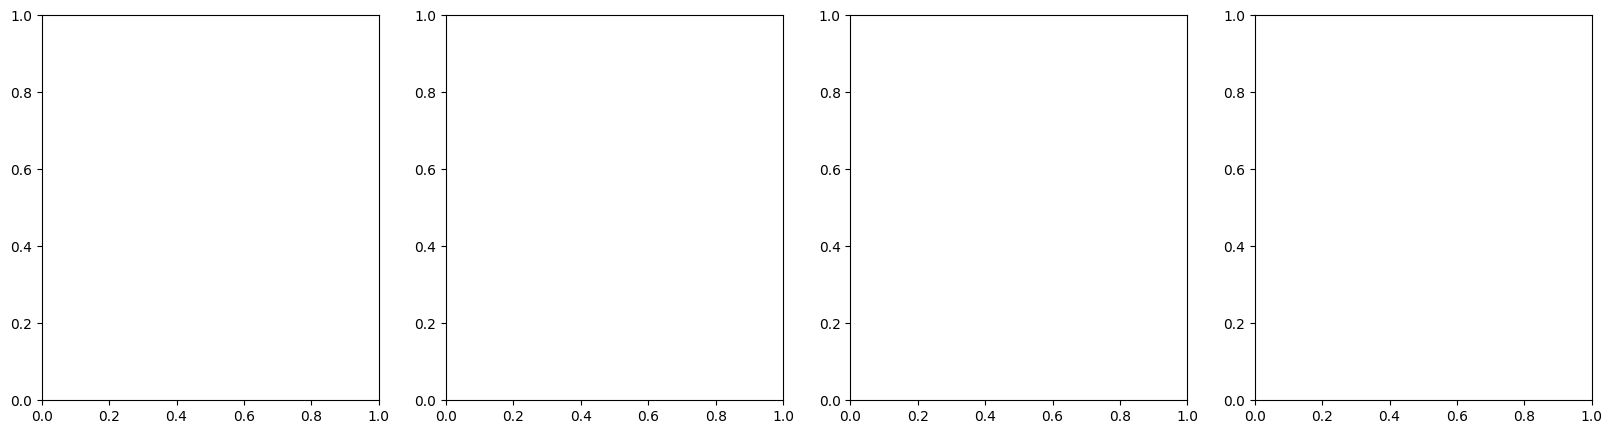

In [37]:
newpath = r'analysis_output' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

def reconstruct_images(images):
    results = {}

    corrupted_image_folder = "128x128 expanded pgm images/"  # Update this with the path to your corrupted images folder

    for image_number, image_infos in images.items():

        corrupted_image_path = os.path.join(corrupted_image_folder, f"expanded_128x128_image{image_number}.pgm")
        corrupted_image = cv2.imread(corrupted_image_path, cv2.IMREAD_GRAYSCALE)

        if corrupted_image is None:
            print(f"Error: Corrupted image {corrupted_image_path} not found.")
            continue

        experiments = {}

        if image_number not in results:
                results[image_number] = {}

        for image_info in image_infos:
            experiment_id = image_info['experiment_id']

            if experiment_id not in experiments:
                experiments[experiment_id] = []

            experiments[experiment_id].append(image_info)

        i_fn = "pgm images/image" + str(image_number) + ".pgm"
        original = cv2.imread(i_fn, cv2.IMREAD_GRAYSCALE)

        for experiment_id, experiment in experiments.items():
            
            # if len(experiment) != 20:
            #     continue

                
            if experiment_id not in results[image_number]:
                results[image_number][experiment_id] = {}

            o = []

            patch_size = experiment[0]['patch_size']
            num_patterns = experiment[0]['num_patterns']

            for e in experiment:
                o.append(e['image'])

            c = corrupted_image

            a = np.mean(o, axis=0)

            reconstruction = (c * 1) + (a * -2)

            fig, axes = plt.subplots(1, 4, figsize=(20, 5))

            crop = 128
            offset = 64

            cropped_corrupted = c[offset:(offset+crop),offset:(offset+crop)]
            cropped_reconstruction = a[offset:(offset+crop),offset:(offset+crop)]
            cropped_combination = reconstruction[offset:(offset+crop),offset:(offset+crop)]
            cropped_original = original[offset:(offset+crop),offset:(offset+crop)]

            experiment_info = {
                'original': cropped_original,
                'reconstruction': cropped_reconstruction,
                'corrupted': cropped_corrupted,
                'patch_size': patch_size,
                'num_patterns': num_patterns,
                'S': 1 - (np.mean(np.abs(cropped_original - cropped_reconstruction)) / 255)
            }

            results[image_number][experiment_id] = experiment_info

            # Display corrupted image
            axes[0].imshow(cropped_corrupted, cmap='gray')
            axes[0].set_title('Corrupted Image')

            # Display reconstruction
            axes[1].imshow(cropped_reconstruction, cmap='gray')
            axes[1].set_title('Average of Predictions')

            # Display combination
            axes[2].imshow(cropped_combination, cmap='gray')
            axes[2].set_title('Combination (Corrupted - Prediction)')

            # Display original
            axes[3].imshow(cropped_original, cmap='gray')
            axes[3].set_title('Original')

            title = "Image: " + str(image_number) + " Predictions: " + str(len(experiment)) + " Patch Size: " + str(patch_size) + " Stored Patterns: " + str(num_patterns)
            fig.suptitle(title)

            plt.savefig("./analysis_output/img" + str(image_number) + '_' + str(experiment_id) + '_' + "comparison" + ".png")
            plt.close()


    return results

results = reconstruct_images(images)

In [ ]:
def iterative_reconstruct_images(images):
    results = {}

    corrupted_image_folder = "128x128 expanded pgm images/"  # Update this with the path to your corrupted images folder

    for image_number, image_infos in images.items():

        corrupted_image_path = os.path.join(corrupted_image_folder, f"expanded_128x128_image{image_number}.pgm")
        corrupted_image = cv2.imread(corrupted_image_path, cv2.IMREAD_GRAYSCALE)

        if corrupted_image is None:
            print(f"Error: Corrupted image {corrupted_image_path} not found.")
            continue

        experiments = {}

        if image_number not in results:
                results[image_number] = {}

        for image_info in image_infos:
            experiment_id = image_info['experiment_id']

            if experiment_id not in experiments:
                experiments[experiment_id] = []

            experiments[experiment_id].append(image_info)

        for experiment_id, experiment in experiments.items():
            
            # if len(experiment) != 20:
            #     continue

                
            if experiment_id not in results[image_number]:
                results[image_number][experiment_id] = []

            o = []

            patch_size = experiment[0]['patch_size']
            num_patterns = experiment[0]['num_patterns']

            n = 0

            i_fn = "pgm images/image" + str(image_number) + ".pgm"
            original = cv2.imread(i_fn, cv2.IMREAD_GRAYSCALE)

            for e in experiment:
                o.append(e['image'])
                n += 1

                c = corrupted_image

                a = np.mean(o, axis=0)

                reconstruction = a


                crop = 128
                offset = 64

                cropped_corrupted = c[offset:(offset+crop),offset:(offset+crop)]
                cropped_reconstruction = reconstruction[offset:(offset+crop),offset:(offset+crop)]
                cropped_original = original[offset:(offset+crop),offset:(offset+crop)]

                experiment_info = {
                    'iteration': n,
                    'original': cropped_original,
                    'reconstruction': cropped_reconstruction,
                    'corrupted': cropped_corrupted,
                    'patch_size': patch_size,
                    'num_patterns': num_patterns,
                    'S': 1 - (np.mean(np.abs(cropped_original - cropped_reconstruction)) / 255)
                }

                results[image_number][experiment_id].append(experiment_info) 

    return results

iterative_results = iterative_reconstruct_images(images)



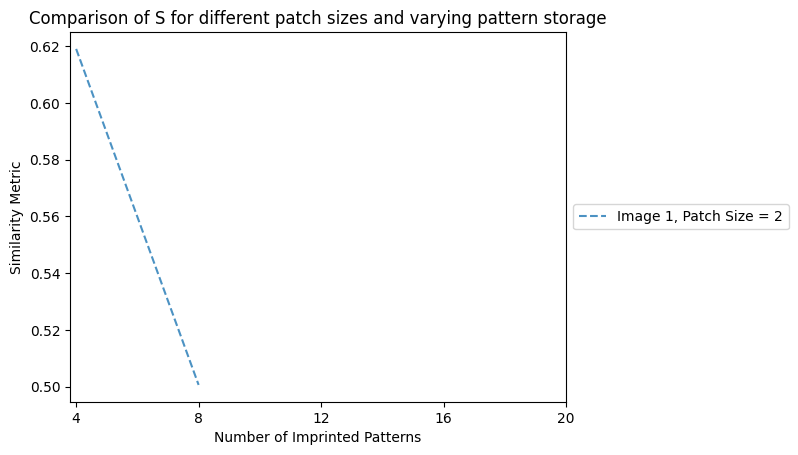

In [ ]:
from matplotlib.cm import tab10

def plot_similarity(results):
    # Dictionary to store colors for each image number
    image_colors = {}

    # plt.figure(figsize=(8, 8))

    for image_number, experiments in results.items():
        patch_size_2_S = []
        patch_size_4_S = []
        num_patterns_2 = []
        num_patterns_4 = []

        for experiment_id, parameters in experiments.items():
            if parameters['patch_size'] == 2:
                patch_size_2_S.append(parameters['S'])
                num_patterns_2.append(parameters['num_patterns'])
            elif parameters['patch_size'] == 4:
                patch_size_4_S.append(parameters['S'])
                num_patterns_4.append(parameters['num_patterns'])

        # Assigning a color for the current image number if not already assigned
        if image_number not in image_colors:
            image_colors[image_number] = plt.cm.tab10(len(image_colors))

        if patch_size_2_S:
            plt.plot(num_patterns_2, patch_size_2_S, label=f'Image {image_number}, Patch Size = 2', color=image_colors[image_number], linestyle='--', alpha=0.8)
        if patch_size_4_S:
            plt.plot(num_patterns_4, patch_size_4_S, label=f'Image {image_number}, Patch Size = 4', color=image_colors[image_number], alpha=0.5)

    plt.xlabel('Number of Imprinted Patterns')
    plt.ylabel('Similarity Metric')
    plt.title('Comparison of S for different patch sizes and varying pattern storage')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Set x-axis ticks
    plt.xticks([4, 8, 12, 16, 20])
    
    plt.savefig("./graphs/similarity_against_imprints.png")
    plt.show()
            

# Example usage:
plot_similarity(results)

In [ ]:
print(len(iterative_results[12][1714612441][2]))
# prints 400

# experiment_info = {
#     'iteration': n,
#     'original': cropped_original,
#     'reconstruction': cropped_reconstruction,
#     'corrupted': cropped_corrupted,
#     'patch_size': patch_size,
#     'num_patterns': num_patterns,
#     'S': 1 - (np.mean(np.abs(cropped_original - cropped_reconstruction)) / 255)
# }

def plot_similarity_over_iterations(experiment_info):

    iterations = []
    similarity = []

    for info in experiment_info:
        iterations.append(info['iteration'])
        similarity.append(info['S'])

    plt.plot(iterations, similarity)
    plt.xlabel('Number of Iterations')
    plt.ylabel('Similarity')
    plt.title('Similarity Over Iterations (Averaging Reconstructions, patch_size=2, num_patterns=10, max_iterations=25)')
    plt.grid(True)
    plt.show()

long_experiment = iterative_results[12][1714612441]

plot_similarity_over_iterations(long_experiment)

KeyError: 12